<a href="https://colab.research.google.com/github/Maccam1234/IncomePools/blob/main/Copy_of_ytscrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add to console in "inspect" to keep session active

function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,60000)

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<ipython-input-13-dd7a6b8f9a08>:30: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


---------------------------
starting youtube search and scrape
Finished scrapping social blade links from youtube in 0.9858 minutes
-----------------------------
starting social blade scrape
Finished social blade scrape in 22.1856 minutes
-----------------------------
starting to get wayback urls from social blade urls
Finished scrapping for wayback urls in 40.4463 minutes
-----------------------------------
starting to scrape wayback
Finished scrapping wayback in 1.2048 minutes


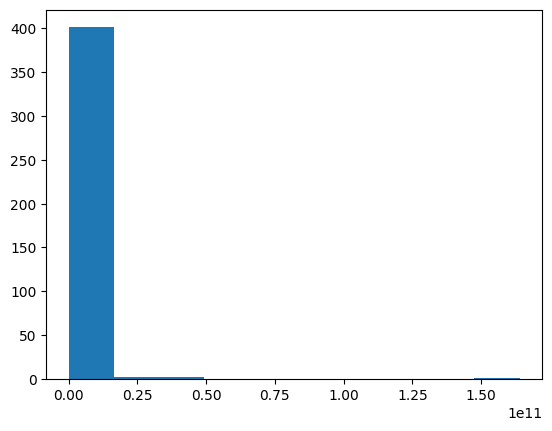

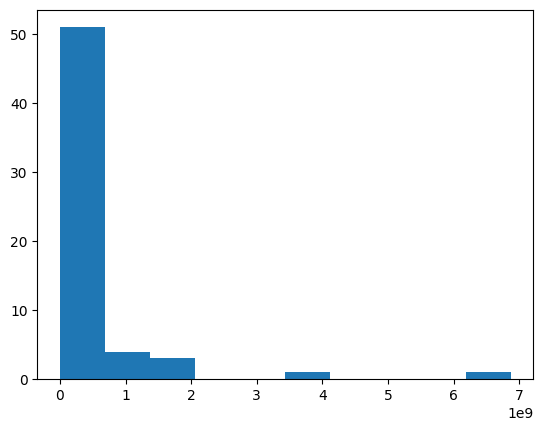

In [ ]:
import random
import requests
import bs4
import lxml
import pandas as pd
import numpy as np
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import time
import matplotlib.pyplot as plt
from google.colab import drive

# URLs must have atleast one save on wayback machine in 2019 or else a blank string will be returned
# urls will contain urls with the format https://socialblade.com/youtube/user/
urls = []

yturl = 'https://www.youtube.com/results?search_query=education+channels&sp=EgIQAg%253D%253D'

tags = []

# browser for loading youtube and wayback
drive.mount('/content/drive/')
# things to make the selenium chrome browser work in colab
service = Service(executable_path=r'chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.headless = True
browser = webdriver.Chrome(service=service,options=chrome_options)



browser.get(yturl)
print("---------------------------\nstarting youtube search and scrape")
tic = time.perf_counter()
# scrolls until youtube has no more results
while True:
    # end_result = "No more results" string at the bottom of the page
    # this will be used to break out of the while loop
    try:
        end_result = browser.find_element(By.XPATH, "//yt-formatted-string[(@id='message') and "
                                                    "(@class = 'style-scope ytd-message-renderer')]").is_displayed()
    except:
        end_result = False
    browser.execute_script("var scrollingElement = (document.scrollingElement || document.body);"
                           "scrollingElement.scrollTop = scrollingElement.scrollHeight;")

    # once element is located, break out of the loop
    if end_result == True:
        break

res = browser.find_element(By.XPATH, "//div[(@id='contents') and (@class = 'style-scope ytd-section-list-renderer')]")
html = res.get_attribute('innerHTML')
soup = bs4.BeautifulSoup(html, 'lxml')
# gets all the yt tags
divs = soup.findAll('span', id='subscribers', class_='style-scope ytd-channel-renderer')

# adds each tag to the tags array
for tag in divs:
    tags.append(tag.get_text())

# adds each tag to the base url to get the channels' social blade url and adds it to urls array
for tag in tags:
    urls.append('https://socialblade.com/youtube/user/' + tag[1:len(tag)])

toc = time.perf_counter()
print(f"Finished scrapping social blade links from youtube in {(toc - tic)/60:0.4f} minutes")

df2023 = pd.DataFrame(columns=['Channel Name', 'Country', 'Channel Type', 'User Creation Date', 'Uploads 2023',
                               'Subscribers 2023', 'Video Views 2023'])

# used to get around socialblade bot detection by pretending to be a user
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36",
    "Referer": "https://targetwebsite.com/page1"
}

# scrape 2023 data from social blade
print('-----------------------------\nstarting social blade scrape')
tic = time.perf_counter()
for x in range(0, len(urls)):
    url = urls[x]
    try:
        # random time intervals to bypass bot detection
        time.sleep(random.random() * 4)
        res = requests.get(url, headers=headers)
        soup = bs4.BeautifulSoup(res.content, 'lxml')

        divs = soup.find('div', id='YouTubeUserTopInfoBlockTop')
        # get first div within YouTubeUserTopInfoBlockTop which is where the channel name is
        titleDiv = divs.find('div')
        title = titleDiv.find('h1')
        channelName = title.get_text().strip()
        # will become an array containing all the info for the channel
        channelInfo = [channelName]

        divs = divs.find('div', id='YouTubeUserTopInfoBlock')
        divs = divs.findAll('div', class_='YouTubeUserTopInfo')
        # just to get creation date, country, channel type before the numbers
        for x in range(3, len(divs)):
            div = divs[x]
            header = div.find('span', class_='YouTubeUserTopLight')
            content = div.find('span', attrs={'style': 'font-weight: bold;'}).get_text()
            while content.find(',') != -1:
                content = content[0:content.find(',')] + content[content.find(',') + 1:len(content)]
            channelInfo.append(content)
        # get the uploads, views and subs after
        for x in range(0, 3):
            div = divs[x]
            header = div.find('span', class_='YouTubeUserTopLight')
            content = div.find('span', attrs={'style': 'font-weight: bold;'}).get_text()
            while content.find(',') != -1:
                content = content[0:content.find(',')] + content[content.find(',') + 1:len(content)]
            channelInfo.append(content)

        # Insert new row of channelInfo
        df2023.loc[len(df2023.index)] = channelInfo
    except:
        df2023.loc[len(df2023.index)] = ['', '', '', '', '', '', '']

toc = time.perf_counter()
print(f"Finished social blade scrape in {(toc - tic)/60:0.4f} minutes")

waybackUrls = []

# gets the wayback urls using the socialblade urls
print('-----------------------------\nstarting to get wayback urls from social blade urls')
tic = time.perf_counter()
for url in urls:
    # bring us to the 2019 calendar for the socialblade site
    url = 'https://web.archive.org/web/20190101000000*/' + url
    # opens the link in chrome
    browser.get(url)
    browser.get(url)

    try:
        # browser probably takes 3 seconds to load
        time.sleep(4)
        # find the html within calendar-grid div
        res = browser.find_element(By.CLASS_NAME, 'calendar-grid')
        html = res.get_attribute("innerHTML")
        soup = bs4.BeautifulSoup(html, 'lxml')

        # finding the first href in the calendar (which will be the first save in 2019)
        link = soup.find('a')
        link = 'https://web.archive.org' + link['href']
        waybackUrls.append(link)
    except:
        # if no saves in 2019
        waybackUrls.append('')

toc = time.perf_counter()
print(f"Finished scrapping for wayback urls in {(toc - tic)/60:0.4f} minutes")

df2019 = pd.DataFrame(columns=['Uploads 2019', 'Subscribers 2019', 'Video Views 2019'])

# scrapes for 2019 data on wayback
print('-----------------------------------\nstarting to scrape wayback')
tic = time.perf_counter()
for url in waybackUrls:
    try:
        res = requests.get(url)
        channelInfo = []
        soup = bs4.BeautifulSoup(res.content, 'lxml')

        divs = soup.find('div', id='YouTubeUserTopInfoBlockTop')

        divs = divs.find('div', id='YouTubeUserTopInfoBlock')
        # all divs in the top bar (subs, views, country, creation date, ...)
        divs = divs.findAll('div', class_='YouTubeUserTopInfo')
        # only need subs views and uploads from 2019 because everything else is already saved from 2023
        for x in range(0, 3):
            div = divs[x]
            header = div.find('span', class_='YouTubeUserTopLight')
            content = div.find('span', attrs={'style': 'font-weight: bold;'}).get_text()
            # gets rid of commas in the numbers
            while content.find(',') != -1:
                content = content[0:content.find(',')] + content[content.find(',') + 1:len(content)]
            channelInfo.append(content)

        # Insert new row of channelInfo
        df2019.loc[len(df2019.index)] = channelInfo
    except:
        df2019.loc[len(df2019.index)] = ['', '', '']

toc = time.perf_counter()
print(f"Finished scrapping wayback in {(toc - tic)/60:0.4f} minutes")

dfFinal = pd.concat([df2023, df2019], axis=1)
dfFinal['Video Views 2023'] = pd.to_numeric(dfFinal['Video Views 2023'])
dfFinal['Video Views 2019'] = pd.to_numeric(dfFinal['Video Views 2019'])
dfFinal['Subscribers 2019'] = pd.to_numeric(dfFinal['Subscribers 2019'])

# this is to convert the 2023 subscriber count from nM to a number in the form n000000 then make it a float
for i in range(0, len(dfFinal['Subscribers 2023'])):
    multiplier = 1
    if dfFinal.at[i, 'Subscribers 2023'].find('M') != -1:
        dfFinal.at[i, 'Subscribers 2023'] = dfFinal.at[i, 'Subscribers 2023'][0:len(dfFinal.at[i,
        'Subscribers 2023']) - 1]
        multiplier = 1000000
    if dfFinal.at[i, 'Subscribers 2023'].find('K') != -1:
        dfFinal.at[i, 'Subscribers 2023'] = dfFinal.at[i, 'Subscribers 2023'][0:len(dfFinal.at[i,
        'Subscribers 2023']) - 1]
        multiplier = 1000
    dfFinal.at[i, 'Subscribers 2023'] = pd.to_numeric(dfFinal.at[i, 'Subscribers 2023']) * multiplier



mean2023 = dfFinal['Video Views 2023'].mean()
mean2019 = dfFinal['Video Views 2019'].mean()
plt.hist(dfFinal['Video Views 2023'])
plt.show()
plt.hist(dfFinal['Video Views 2019'])
plt.show()

dfFinal.to_csv('youtuberData_2019_2023.csv')

!cp youtuberData_2019_2023.csv "drive/My Drive/Cameron Summer Research"
